In [161]:
### DATA CLEANING FOR QUESTION: SPEED OF VACCINATION ROLLOUT BY COUNTRY GDP ###

In [162]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [163]:
# importing and inspecting csv
df_cases = pd.read_csv('Resources/Data_Clean_Cases.csv')
df_cases.head()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [164]:
# isolate columns to get gdp info by country
df_cases.columns
df_gdp = df_cases[["location","gdp_per_capita"]].groupby("location").max()
# reset index
df_gdp.reset_index(level=0, inplace=True)
# inspect gdp data to create reasonable groups for analysis
print(df_gdp.describe())

       gdp_per_capita
count      179.000000
mean     18776.122073
std      19687.204490
min        661.240000
25%       4338.764000
50%      12236.706000
75%      26792.862500
max     116935.600000


In [169]:
# create 4 gdp per capita groups based on 25,50,75 percentiles
df_gdp.loc[df_gdp["gdp_per_capita"] < 4000, 'gdp_grp'] = 'low'
df_gdp.loc[(df_gdp["gdp_per_capita"] >= 4000) & (df_gdp["gdp_per_capita"] < 12000), 'gdp_grp'] = 'low_to_mid'
df_gdp.loc[(df_gdp["gdp_per_capita"] >= 12000) & (df_gdp["gdp_per_capita"] < 26000), 'gdp_grp'] = 'mid_to_high'
df_gdp.loc[df_gdp["gdp_per_capita"] >= 26000, 'gdp_grp'] = 'high'    

In [170]:
# retrieving first covid case start date by country and saving to dataframe
covid_start_date = df_cases.loc[df_cases["total_cases"]>0,(["date","location"])].groupby("location")["date"].min()
covid_start_date_df = pd.DataFrame(covid_start_date)
covid_start_date_df
covid_start_date_df.reset_index(level=0, inplace=True)

In [171]:
# retrieving new_vaccination starting date by country and saving to dataframe
vaccination_start_date = df_cases.loc[df_cases["new_vaccinations"]>0,(["date","location"])].groupby("location")["date"].min()
vaccination_start_date
vaccination_start_date_df = pd.DataFrame(vaccination_start_date)


In [172]:
# merging covid_start_date_df to vaccination_start_date_df
covid_and_vax_dates = pd.merge(covid_start_date_df,vaccination_start_date_df, how="left", on="location", suffixes=("_covid_start","_first_vax"))

In [173]:
# insert % vaccinated column for to find latest (max) value
df_cases["%vaccinated"] = df_cases["people_fully_vaccinated"]/df_cases["population"]*100

In [174]:
# # finding latest figure of %vaccinated by country for heatmap
current_vax = df_cases.loc[df_cases["%vaccinated"]>0,(["iso_code","location","date","%vaccinated"])].groupby(["location","iso_code"])[["%vaccinated"]].max()

#finding first row of 25% vaccinated by country
vax25 = df_cases.loc[df_cases["%vaccinated"]>25,(["location","date","%vaccinated"])].groupby("location")["date"].min()

#finding first row of 50% vaccinated by country
vax50 = df_cases.loc[df_cases["%vaccinated"]>50,(["location","date","%vaccinated"])].groupby("location")["date"].min()

#finding first row of 75% vaccinated by country
vax75 = df_cases.loc[df_cases["%vaccinated"]>75,(["location","date","%vaccinated"])].groupby("location")[["date"]].min()

In [175]:
# merging vaccination dfs to covid_and_vax_dates df
start_25_df = pd.merge(covid_and_vax_dates, vax25, how="left", on="location")
start_25_50_df = pd.merge(start_25_df, vax50, how="left", on="location", suffixes=("_25pc","_50pc"))
start_25_50_df = start_25_50_df.rename(columns={"date":"date_50pc"})
start_25_50_75_df = pd.merge(start_25_50_df, vax75, how="left", on="location")
start_25_50_75_df = start_25_50_75_df.rename(columns={"date":"date_75pc"})
whole_vax_df = pd.merge(start_25_50_75_df, current_vax, how="left", on="location")

In [188]:
# merging whole vax and gdp groups 
whole_vax_gdp_groups = pd.merge(whole_vax_df, df_gdp, how="left", on="location")

# initialise columns for figure 1 with zeros
whole_vax_gdp_groups["has_25pc"] = 0
whole_vax_gdp_groups["has_50pc"] = 0
whole_vax_gdp_groups["has_75pc"] = 0
# populating rows for new columns
whole_vax_gdp_groups.loc[whole_vax_gdp_groups["%vaccinated"]>25, "has_25pc"] = 1 
whole_vax_gdp_groups.loc[whole_vax_gdp_groups["%vaccinated"]>50, "has_50pc"] = 1 
whole_vax_gdp_groups.loc[whole_vax_gdp_groups["%vaccinated"]>75, "has_75pc"] = 1 
# creating new df of notnull values
df = whole_vax_gdp_groups[whole_vax_gdp_groups["gdp_grp"].notnull()]
# create groupby df for bar chart
df = df.groupby("gdp_grp")[["has_25pc","has_50pc","has_75pc"]].mean()
# changing cols "has_25pc","has_50pc","has_75pc" to percentages
df[["has_25pc","has_50pc","has_75pc"]] = round(df[["has_25pc","has_50pc","has_75pc"]]*100,1)
df.reset_index(level=0, inplace=True)
df

,gdp_grp,has_25pc,has_50pc,has_75pc
0,high,97.9,89.4,19.1
1,low,2.3,2.3,2.3
2,low_to_mid,42.2,15.6,0.0
3,mid_to_high,72.1,25.6,0.0


In [189]:
# creating function to reorder gdp_grp for plot
def gdp_order(row):
    if row == "low":
        return 0
    elif row == "low_to_mid":
        return 1
    elif row == "mid_to_high":
        return 2
    else:
        return 3

df["gdp_order"] = df["gdp_grp"].apply(gdp_order)
df = df.sort_values("gdp_order")
df

,gdp_grp,has_25pc,has_50pc,has_75pc,gdp_order
1,low,2.3,2.3,2.3,0
2,low_to_mid,42.2,15.6,0.0,1
3,mid_to_high,72.1,25.6,0.0,2
0,high,97.9,89.4,19.1,3


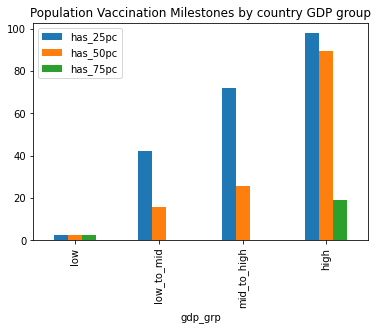

In [190]:
# Create bar chart of vaccination milestones (25,50,75%) by GDP group
df.plot(x="gdp_grp", y=["has_25pc","has_50pc","has_75pc"], kind="bar")
plt.title("Population Vaccination Milestones by country GDP group")
plt.show()

In [197]:
# calculate days to first vaccination
whole_vax_gdp_groups["days_to_first_vax"] = (pd.to_datetime(whole_vax_gdp_groups["date_first_vax"]) - pd.to_datetime(whole_vax_gdp_groups["date_covid_start"])).dt.days
df2 = whole_vax_gdp_groups[whole_vax_gdp_groups["days_to_first_vax"].notnull()]
df2 = whole_vax_gdp_groups[whole_vax_gdp_groups["gdp_grp"].notnull()]

# ordering them for second figure (function does not work here)
df2.loc[df2["gdp_grp"] == "low", "gdp_grp"] = "a_low"
df2.loc[df2["gdp_grp"] == "low_to_mid", "gdp_grp"] = "b_low_to_mid"
df2.loc[df2["gdp_grp"] == "mid_to_high", "gdp_grp"] = "c_mid_to_high"
df2.loc[df2["gdp_grp"] == "high", "gdp_grp"] = "d_high"


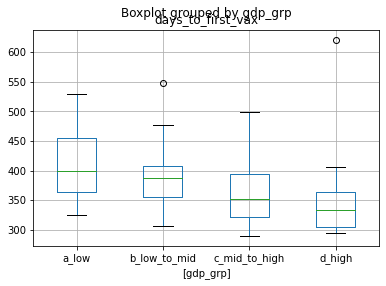

In [198]:
# Create boxplot of days to vaccination by gdp group
# note: needs fixing title and axis names
df2.boxplot(column=["days_to_first_vax"], by=["gdp_grp"])
plt.show()